In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/spam.csv', encoding = "ISO-8859-1")
data = data[['v1', 'v2']].rename(columns = {'v1': 'label', 'v2': 'text'})
data.loc[data.label == 'ham', 'label'] = 0
data.loc[data.label == 'spam', 'label'] = 1

In [3]:
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.text, data.label.astype('int'), test_size=0.2, random_state=0, shuffle=True, stratify=data.label)

# TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                                   max_features = int(np.ceil(len(X_train)/2)), 
                                   stop_words = 'english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()
X_train_tfidf.shape

(4457, 2229)

              precision    recall  f1-score   support

    not spam       0.98      1.00      0.99       966
        spam       0.98      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



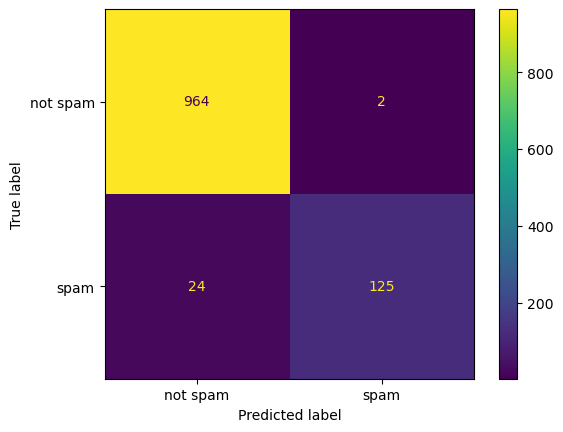

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
preds = rf.predict(X_test_tfidf)
print(classification_report(y_test, preds, target_names=['not spam', 'spam']))

confusion_matrix = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                    display_labels = ['not spam', 'spam'])
cm_display.plot()
plt.show()

# Embedding

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L12-v2')
X_train_embedding = np.stack(X_train.apply(lambda row: np.array(model.encode(row))).values)
X_test_embedding = np.stack(X_test.apply(lambda row: np.array(model.encode(row))).values)

/Users/frank/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
X_train_embedding.shape

(4457, 384)

In [9]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_embedding, y_train)
preds = rf2.predict(X_test_embedding)
print(classification_report(y_test, preds, target_names=['not spam', 'spam']))

              precision    recall  f1-score   support

    not spam       0.96      1.00      0.98       966
        spam       1.00      0.70      0.83       149

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115



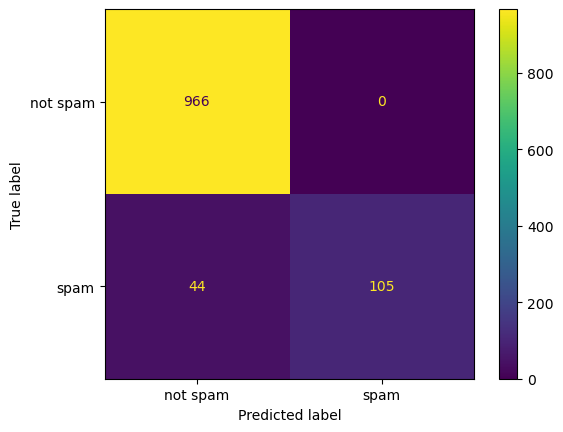

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
preds = rf2.predict(X_test_embedding)
confusion_matrix = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['not spam', 'spam'])
cm_display.plot()
plt.show()

# Transformers/BERT

In [12]:
from transformers.utils import logging
from transformers import AutoTokenizer
logging.set_verbosity(40)
from datasets import Dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [13]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

train = Dataset.from_dict({'labels': y_train, 'text': X_train})
test = Dataset.from_dict({'labels': y_test, 'text': X_test})

train_tokenized = train.map(preprocess_function, batched=True)
test_tokenized = test.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x2bb8e0430> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
 50%|██████████████████████▌                      | 1/2 [00:00<00:00, 64.16ba/s]


In [14]:
import evaluate
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "not spam", 1: "spam"}
label2id = {"not spam": 0, "spam": 1}

In [15]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
logging.set_verbosity(40)

'''model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)'''

model = AutoModelForSequenceClassification.from_pretrained(
    "spam_model/checkpoint-2800", local_files_only=True
    )

In [16]:
training_args = TrainingArguments(
    output_dir="spam_model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#trainer.train()

In [17]:
X_test_tokenized = X_test.apply(tokenizer, truncation=True)
predictions = trainer.predict(test_tokenized)
preds = np.argmax(predictions.predictions, axis=-1)
print(classification_report(y_test, preds, target_names=['not spam', 'spam']))

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1115
  Batch size = 32
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


              precision    recall  f1-score   support

    not spam       0.99      1.00      1.00       966
        spam       0.99      0.97      0.98       149

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.99      1115
weighted avg       0.99      0.99      0.99      1115



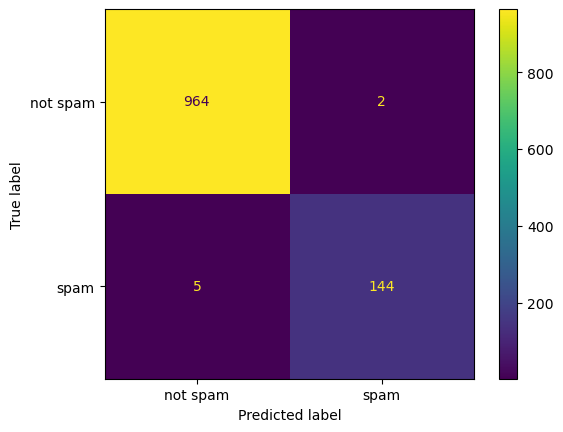

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['not spam', 'spam'])
cm_display.plot()
plt.show()

# Shap

In [19]:
import shap
from transformers import TextClassificationPipeline
classifier = TextClassificationPipeline(model = model, tokenizer = tokenizer)
explainer = shap.Explainer(classifier) 

In [20]:
text = 'Congrats! You have WON $1000 prize!'
shap_values = explainer([text])
shap.plots.text(shap_values[0])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [21]:
text = 'Thank you for your participation. You have not won the prize.'
shap_values = explainer([text])
shap.plots.text(shap_values[0])